# Infer ***golgi*** - part 6️⃣

--------------
OBJECTIVE:  ✅ Infer sub-cellular component ***golgi complex***  in order to understand interactome 

Dependencies:
The ***golgi***  inference rely on the **cytoplasm** mask. 

## preamble

1. imports
2. setup
3. infer nuclei mask
4. infer cellmask mask
5. infer cytoplasm mask
6. infer golgi
    * pre-processing
    * core processing
    * post processing


## IMPORTS

In [4]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper, dot_3d_wrapper

from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter, hole_filling
from skimage.morphology import ball 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))
from infer_subc.core.file_io import (read_czi_image, 
                                                                    list_image_files)
from infer_subc.core.img import *
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )        

from infer_subc.organelles import fixed_infer_cellmask_fromaggr, fixed_infer_nuclei, infer_cytoplasm, find_optimal_Z


%load_ext autoreload
%autoreload 2

# additional imports for nuc/cellmask/cytoplasm
from collections import defaultdict
from scipy import ndimage as ndi
from aicssegmentation.core.MO_threshold import MO
from skimage import filters
from skimage.segmentation import watershed
from skimage.morphology import (binary_erosion,
                                remove_small_holes)
from skimage.measure import label



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SETUP
CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

In [2]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/infer-subc"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\Anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## INFER NUCLEI MASK

Using function defined in 01_infer_nuclei_3D.ipynb


In [5]:
def _infer_nuclei_3D( in_img: np.ndarray,
                       median_sz: int, 
                       gauss_sig: float,
                       thresh_factor: float,
                       thresh_min: float,
                       thresh_max: float,
                       max_hole_w: int,
                       small_obj_w: int,
                       sz_filter_method: str
                     ) -> np.ndarray:
    """
    Procedure to infer 3D nuclei segmentation from multichannel z-stack input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: Optional[np.ndarray] = None
        mask
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimum object size cutoff for nuclei post-processing
    sz_filter_method: str
        method for size filtering; either "3D" or "slice_by_slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    ###################
    # INPUT
    ################### 
    nuc_ch = NUC_CH
    nuclei = select_channel_from_raw(in_img, nuc_ch)


    ###################
    # PRE_PROCESSING
    ###################                
    nuclei = min_max_intensity_normalization(nuclei)
    nuclei = median_filter_slice_by_slice(nuclei,
                                          size=median_sz)
    nuclei = image_smoothing_gaussian_slice_by_slice(nuclei,
                                                     sigma=gauss_sig )


    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                           thresh_factor=thresh_factor, 
                                           thresh_min=thresh_min, 
                                           thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = hole_filling(nuclei_object, 
                                 hole_min=0, 
                                 hole_max=max_hole_w**2, 
                                 fill_2d=True)

    nuclei_object = size_filter(nuclei_object, 
                                min_size = small_obj_w**3, 
                                method = sz_filter_method,
                                connectivity=1)


    return nuclei_object


def _fixed_infer_nuclei_3D(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 5
    small_obj_w = 15
    sz_filter_method = "3D"

    return _infer_nuclei_3D( in_img,
                             median_sz,
                             gauss_sig,
                             threshold_factor,
                             thresh_min,
                             thresh_max,
                             max_hole_w,
                             small_obj_w,
                             sz_filter_method )


_NU_object =  _fixed_infer_nuclei_3D(img_data) 
NU_labels = label(_NU_object)

## GET CELLMASK

Using function defined in 02_infer_cellmask_fromaggr_3D.ipynb

In [6]:
def _raw_soma_MCZ(img_in):
    """ define cellmask image
    """
    SOMA_W = (6.,1.,2.)
    SOMA_CH = (LYSO_CH,ER_CH,GOLGI_CH)
    img_out = np.zeros_like(img_in[0]).astype(np.double)
    for w,ch in zip(SOMA_W,SOMA_CH):
        img_out += w*img_in[ch]
    return img_out


def _non_linear_soma_transform_MCZ(in_img):
    """ non-linear distortion to fill out cellmask
    log + edge of smoothed composite
    """
    # non-Linear processing
    log_img, d = log_transform(in_img.copy()) 
    return intensity_normalization(log_img,scaling_param=[0])


def _masked_object_thresh(
    structure_img_smooth: np.ndarray, th_method: str, cutoff_size: int, th_adjust: float
) -> np.ndarray:
    """
    wrapper for applying Masked Object Thresholding with just two parameters via `MO` from `aicssegmentation`
    Parameters
    ------------
    structure_img_smooth: np.ndarray
        a 3d image
    th_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cutoff_size: 
        Masked Object threshold `size_min`
    th_adjust: 
        Masked Object threshold `local_adjust`

    Returns
    -------------
        np.ndimage 

    """

    struct_obj = MO(
        structure_img_smooth,
        global_thresh_method=th_method,
        object_minArea=cutoff_size,
        extra_criteria=True,
        local_adjust=th_adjust,
        return_object=False,
        dilate=True,
    )
    return struct_obj


def _masked_inverted_watershed(img_in, markers, mask):
    """wrapper for watershed on inverted image and masked

    """
    labels_out = watershed(
                1. - img_in,
                markers=markers,
                connectivity=3,
                mask=mask,
                )
    return labels_out


def _choose_max_label(raw_signal: np.ndarray, labels_in: np.ndarray):
    """ keep only the label with the maximum raw signal

    """

    all_labels = np.unique(labels_in)[1:]

    total_signal = [raw_signal[labels_in == label].sum() for label in all_labels]
    # combine NU and "labels" to make a SOMA
    keep_label = all_labels[np.argmax(total_signal)]

    labels_max = np.zeros_like(labels_in)
    labels_max[labels_in==keep_label] = 1
    return labels_max

In [7]:
def _infer_cellmask_fromaggr_3D(in_img: np.ndarray,
    nuclei_labels: np.ndarray,
    median_sz_soma: int,
    gauss_sig_soma: float,
    gauss_truc_rang: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    max_hole_w_soma: int,
    small_obj_w_soma: int
) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels:
        a 3d mask of nuclei
    median_sz_soma: 
        width of median filter for _soma_ signal
    gauss_sig_soma: 
        sigma for gaussian smoothing of _soma_ signal
    gauss_truc_rang:
        cutoff value for gaussian
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w_soma: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w_soma: 
        minimu object size cutoff for cellmask signal post-processing

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask

    """

    ###################
    # EXTRACT
    ###################
    struct_img = _raw_soma_MCZ(in_img)


    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- cellmask
    struct_img = min_max_intensity_normalization(struct_img)

    # make a copy for post-post processing
    scaled_signal = struct_img.copy()

    # Linear-ish processing
    struct_img = median_filter_slice_by_slice(struct_img, 
                                              size=median_sz_soma)

    struct_img = ndi.gaussian_filter(struct_img,
                                     sigma=gauss_sig_soma,
                                     mode="nearest",
                                     truncate=gauss_truc_rang)

    struct_img_non_lin = _non_linear_soma_transform_MCZ(struct_img)
   

    ###################
    # CORE_PROCESSING
    ###################    
    struct_obj = _masked_object_thresh(struct_img_non_lin, 
                                       th_method=mo_method, 
                                       cutoff_size=mo_cutoff_size, 
                                       th_adjust=mo_adjust)               


    ###################
    # POST_PROCESSING
    ###################
    struct_obj = hole_filling(struct_obj, 
                              hole_min =0 , 
                              hole_max=max_hole_w_soma**2, 
                              fill_2d = True) 

    struct_obj = size_filter_2D(struct_obj, 
                                min_size= small_obj_w_soma**3, 
                                connectivity=1)

    labels_out = _masked_inverted_watershed(struct_obj, nuclei_labels, struct_obj)


    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    soma_out = _choose_max_label(struct_img, labels_out)

    return soma_out


def _fixed_infer_cellmask_fromaggr_3D(in_img: np.ndarray, nuclei_labels: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_object:
        a 3d mask of nuclei

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask
    """
    
    ###################
    # PARAMETERS
    ###################   
    median_sz_soma = 15
    gauss_sig_soma = 1.34
    gauss_truc_rang = 3.0
    mo_method = "ave"
    mo_adjust = 0.15
    mo_cutoff_size = 50
    max_hole_w_soma = 100
    small_obj_w_soma = 45

    soma_out = _infer_cellmask_fromaggr_3D(in_img,
                              nuclei_labels,
                              median_sz_soma,
                              gauss_sig_soma,
                              gauss_truc_rang,
                              mo_method,
                              mo_adjust,
                              mo_cutoff_size,
                              max_hole_w_soma,
                              small_obj_w_soma) 

    return soma_out


SO_label =  _fixed_infer_cellmask_fromaggr_3D(img_data, NU_labels) 

intensity normalization: min-max normalization with NO absoluteintensity upper bound


## GET CYTOSOL MASK


In [8]:
#selecting single nuclei that matches the single cytoplasm selected above
NU_object = np.logical_and(SO_label,NU_labels)

In [9]:
def _infer_cytoplasm(soma_mask, nuclei_object, erode_nuclei = True):
    """
    Procedure to infer cytoplasm from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal

    soma_mask: 
        a 3d image containing the cellmask signal

    erode_nuclei: 
        should we erode?

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """

    if erode_nuclei:
        cytoplasm_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        # cytoplasm_mask = np.logical_xor(soma_mask, binary_erosion(nuclei_object))
    else:
        cytoplasm_mask = np.logical_and(soma_mask, ~nuclei_object)
        # cytoplasm_mask = np.logical_xor(soma_mask, nuclei_object)


    return cytoplasm_mask


cytoplasm_mask = _infer_cytoplasm(SO_label, NU_object) 

---------------------

## infer ***golgi complex***

## summary of steps 
INPUT
- channel 4
- cytoplasm mask

PRE-PROCESSING
-   non-local noise reduction
  - size:4, distance:2, cut-off:0.1

CORE-PROCESSING
- adaptive Otsu
    - diameter: (4,100)
  - two classes
    - threshold smoothing scale: 1.34
    - threshold correction factor: .75
    - threshold bounds: (0.14, 1)
    - adaptive window: 20 pixels

  - adaptive Sauvola
    - threshold smoothing scale: 0
    - threshold correction factor: .6
    - threshold bounds: (0. ,1.0)
    - adaptive window: 20 pixels

- POST-PROCESSING
  - N/A

OUTPUT
- inferred  ***golgi*** object


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> As per the Allen Cell segmenter sialyltransferase 1 (ST6GAL1) a potential Golgi segmenter. e.g. [Allen Cell](https://www.allencell.org/cell-observations/category/golgi-apparatus).    using [seg_st6gal1.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_st6gal1.py") and [playground_st6gal1.ipynb]("../../../../aics-segmentation/lookup_table_demo/playground_st6gal1.ipynb")


>#### ASIDE: Perform topology-preserving thinning 
>There are two parameters:
>* `thin_dist_preserve`: Half of the minimum width you want to keep from being thinned. For example, when the object width is smaller than 4, you don't want to make this part even thinning (may break the thin object and alter the topology), you can set `thin_dist_preserve` as `2`.
>* `thin_dist`: the amount to thin (has to be an positive integer). The number of pixels to be removed from outter boundary towards center


## INPUT prototype

In [10]:

###################
# INPUT
###################
raw_golgi = select_channel_from_raw(img_data, GOLGI_CH)

In [11]:
viewer = napari.Viewer()

In [12]:
viewer.add_image(
    raw_golgi,
    scale=scale
)

<Image layer 'raw_golgi' at 0x1a9f197b400>

## PRE-PROCESSING prototype


In [14]:
###################
# PRE_PROCESSING
###################
golgi_norm = min_max_intensity_normalization( raw_golgi )

med_filter_size = 3  
gaussian_smoothing_sigma = 1.34

golgi_med = median_filter_slice_by_slice(golgi_norm, size=med_filter_size)

golgi_gaus = image_smoothing_gaussian_slice_by_slice(golgi_med,
                                                    sigma=gaussian_smoothing_sigma)

struct_img = golgi_gaus

In [15]:
viewer.add_image(
    golgi_med,
    scale=scale
)

viewer.add_image(
    golgi_gaus,
    scale=scale
)

<Image layer 'golgi_gaus' at 0x1a9985520d0>

## CORE PROCESSING prototype

In [59]:
###################
# CORE_PROCESSING
###################
################################
## PARAMETERS for this step ##
cell_wise_min_area = 1200
threshold_adjust = 1.2 #default is 0.98
thin_dist_preserve = 4
thin_dist = 0
dot_3d_scale = 3
dot_3d_cutoff = 0.1


###################
# CORE_PROCESSING
###################

bw, object_for_debug = MO(struct_img, 
                        global_thresh_method='med', 
                        object_minArea=cell_wise_min_area, 
                        local_adjust=threshold_adjust,
                        return_object=True)


bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)


################################
## PARAMETERS for this step ##
#s3_param = [[1.6, 0.02]]
s3_param = [(dot_3d_scale, dot_3d_cutoff)]
################################

bw_extra = dot_3d_wrapper(struct_img, s3_param)
# bw_extra = dot_2d_slice_by_slice_wrapper(struct_img, s3_param)

bw_combine = np.logical_or(bw_extra, bw_thin)


In [60]:
viewer.add_image(
    bw,
    scale=scale
)
viewer.add_image(
    bw_thin,
    scale=scale
)
viewer.add_image(
    bw_extra,
    scale=scale
)
viewer.add_image(
    bw_combine,
    scale=scale
)  

<Image layer 'bw_combine' at 0x1a9858a91c0>

## POST-PROCESSING prototype

In [61]:

###################
# POST_PROCESSING
###################
golgi_masked = apply_mask(bw_combine, cytoplasm_mask)
    
small_object_width = 3

golgi_masks = size_filter(golgi_masked, 
                            min_size= small_object_width**3, 
                            connectivity=1)

golgi_objects = label(golgi_masks)

In [62]:
viewer.add_image(
    golgi_masked,
    scale=scale
)
viewer.add_image(
    golgi_masks,
    scale=scale
)
viewer.add_labels(
    golgi_objects,
    scale=scale
)


<Labels layer 'golgi_objects' at 0x1a987350b50>

## DEFINE `infer_golgi` function

Based on the _prototyping_ above define the function to infer the golgi.  


In [72]:
##########################
#  infer_golgi
##########################
def _infer_golgi_3D(
            in_img: np.ndarray,
            cytoplasm_mask: np.ndarray,
            median_sz: int,
            gauss_sig: float,
            mo_method: str,
            mo_adjust: float,
            mo_cutoff_size: int,
            min_thickness: int,
            thin: int,
            dot_scale: float,
            dot_cut: float,
            small_obj_w: int,
        ) -> np.ndarray:

    """
    Procedure to infer golgi from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    soma_mask: 
        mask 
    median_sz: 
        width of median filter for signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    min_thinkness: 
        Half of the minimum width you want to keep from being thinned.
        For example, when the object width is smaller than 4, you don't
        want to make this part even thinner (may break the thin object
        and alter the topology), you can set this value as 2.
    thin: 
        the amount to thin (has to be an positive integer). The number of
         pixels to be removed from outter boundary towards center.
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    
    Returns
    -------------
    golgi_object
        mask defined extent of golgi object
    """
    golgi_ch = GOLGI_CH


    ###################
    # EXTRACT
    ###################    
    golgi = select_channel_from_raw(in_img, golgi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    golgi = min_max_intensity_normalization(golgi)

    golgi = median_filter_slice_by_slice(golgi, size=median_sz)

    golgi = image_smoothing_gaussian_slice_by_slice(golgi, sigma=gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    bw, debud = MO(golgi, global_thresh_method=mo_method, object_minArea=mo_cutoff_size, local_adjust=mo_adjust, return_object=True)
    # bw = masked_object_thresh(golgi, th_method=mo_method, cutoff_size=mo_cutoff_size, th_adjust=mo_adjust)

    bw_thin = topology_preserving_thinning(bw, min_thickness, thin)

    s3_param = [(dot_scale, dot_cut)]
    # bw_extra = dot_2d_slice_by_slice_wrapper(golgi, s3_param)
    bw_extra = dot_3d_wrapper(golgi, s3_param)

    bw = np.logical_or(bw_extra, bw_thin)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = apply_mask(bw, cytoplasm_mask)

    struct_obj = size_filter(struct_obj, 
                            min_size= small_obj_w**3, 
                            connectivity=1)


    return struct_obj

## DEFINE `_fixed_infer_golgi` function


In [73]:
##########################
#  fixed_infer_golgi
##########################
def _fixed_infer_golgi_3D(in_img: np.ndarray, 
                        cytoplasm_mask: Optional[np.ndarray] = None
                        ) -> np.ndarray:
    """
    Procedure to infer golgi from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytoplasm_mask: 
        mask

    Returns
    -------------
   golgi_object
        mask defined extent of golgi object
    """


    median_sz = 3
    gauss_sig = 1.34
    mo_method = "med"
    mo_adjust = 1.2
    mo_cutoff_size = 1200
    min_thickness = 4
    thin = 0
    dot_scale = 3
    dot_cut = 0.1
    small_obj_w = 3

    return _infer_golgi_3D(
        in_img,
        cytoplasm_mask,
        median_sz,
        gauss_sig,
        mo_method,
        mo_adjust,
        mo_cutoff_size,
        min_thickness,
        thin,
        dot_scale,
        dot_cut,
        small_obj_w,
    )

# TEST  `infer_golgi` function

In [74]:

_golgi_object =  _fixed_infer_golgi_3D(img_data, cytoplasm_mask) 


In [76]:
_golgi_labels = label(_golgi_object)

In [77]:
viewer.add_image(
    _golgi_object,
    scale=scale
)
viewer.add_labels(
    _golgi_labels,
    scale=scale
)

<Labels layer '_golgi_labels' at 0x1a98b5cad60>

2D-TO-3D TRANSITION STOPPED HERE

In [25]:
from infer_subc.organelles import infer_golgi, fixed_infer_golgi

golgi_object =  fixed_infer_golgi(img_2D, cytoplasm_mask) 


## Visualize  2


In [26]:

viewer.add_image(
    _golgi_object,
    scale=scale
)
viewer.add_image(
    golgi_object,
    scale=scale
)
viewer.add_labels(
    label(golgi_object),
    scale=scale
)

<Labels layer 'Labels' at 0x175acf9a0>

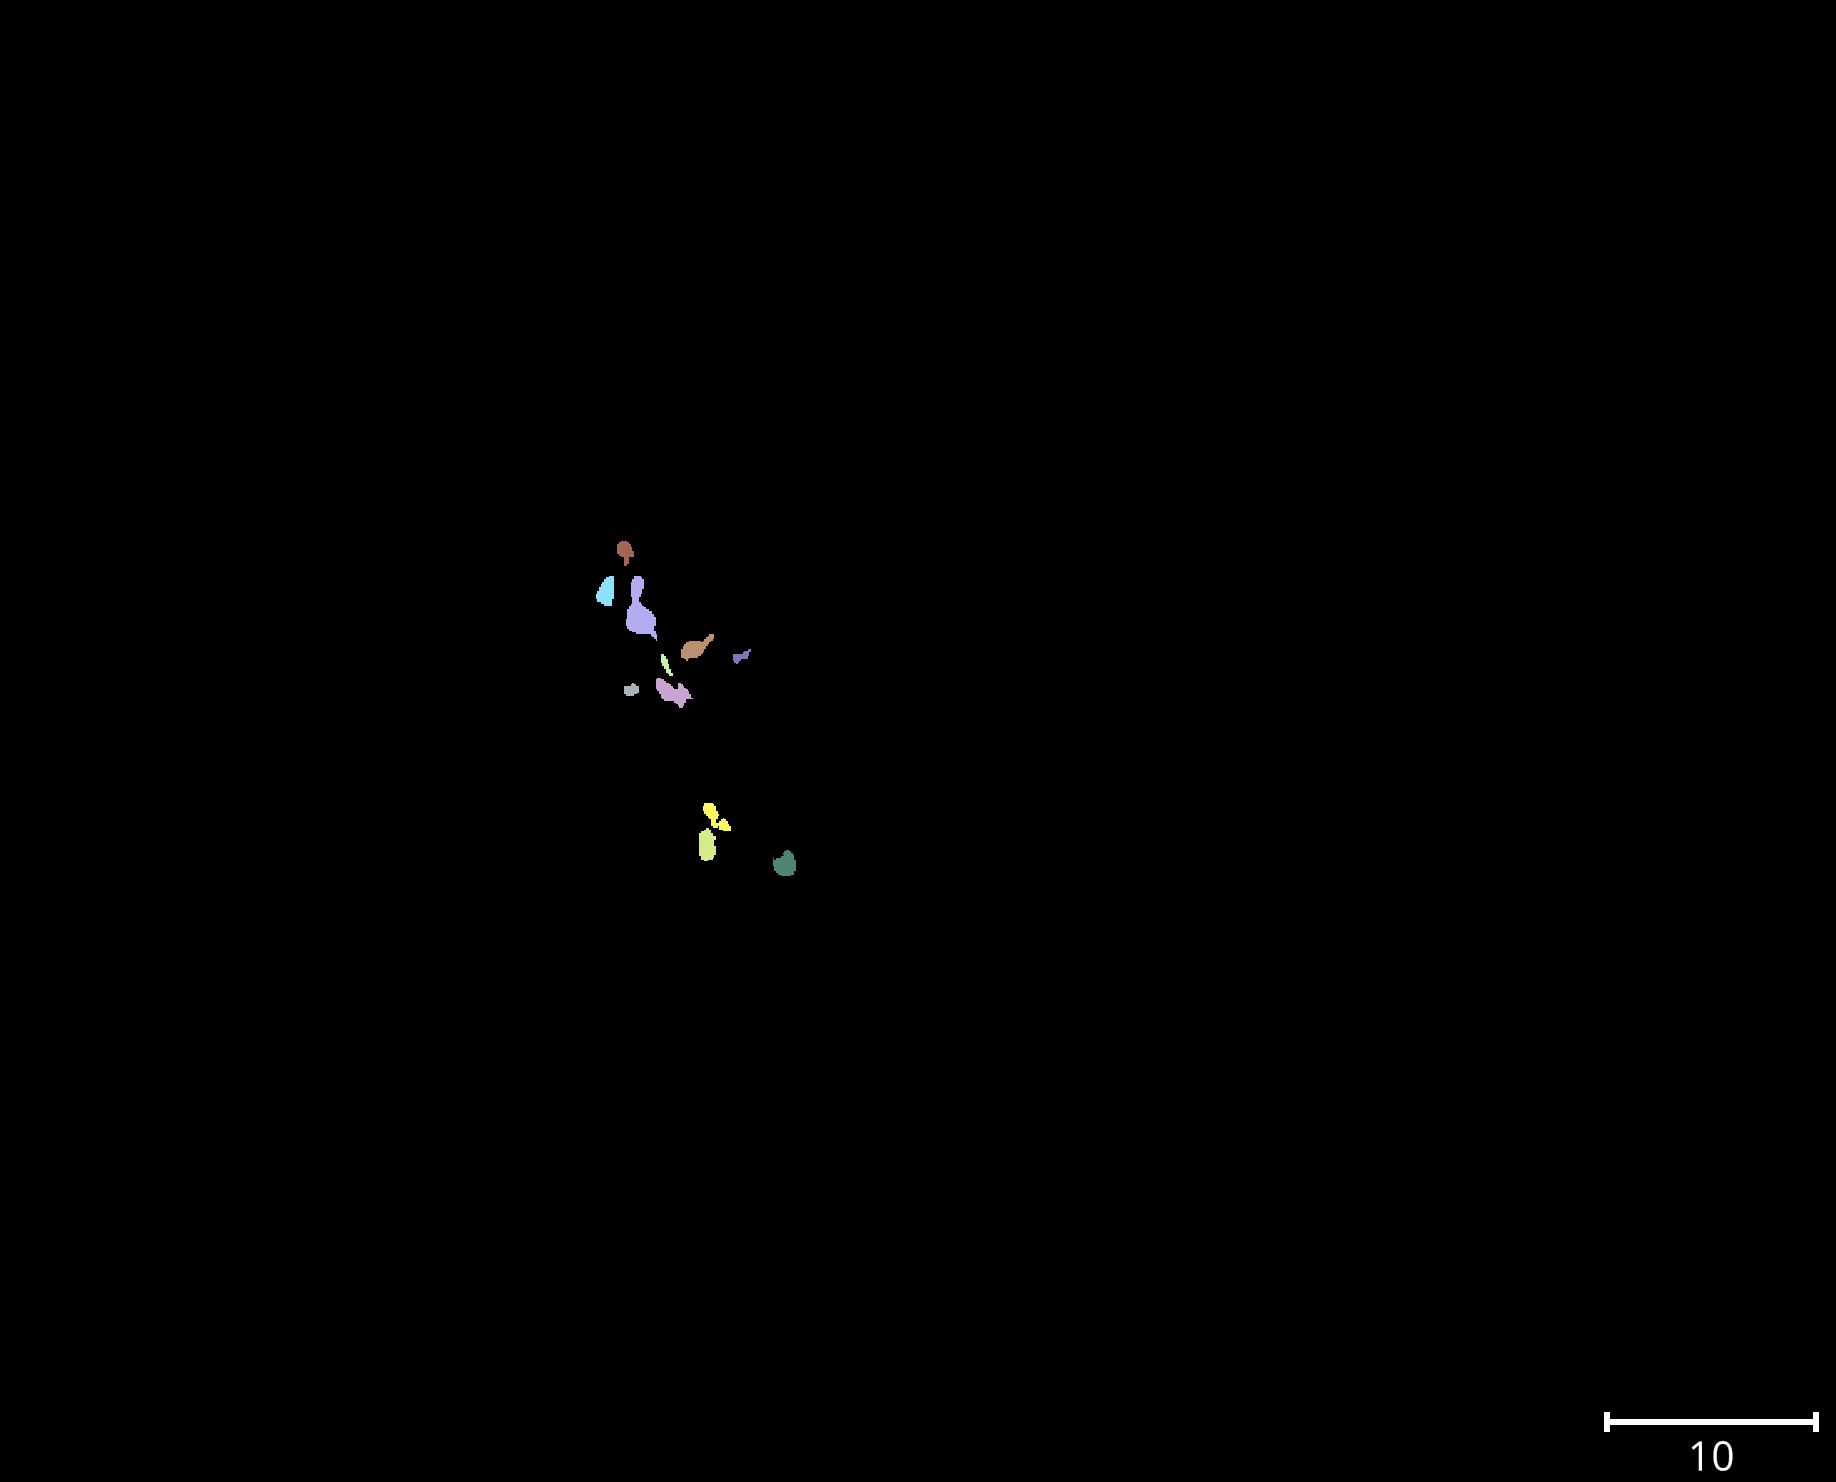

In [27]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [28]:
viewer.close()

-----------------
Write the `infer_lyso` spec to the widget json 

In [29]:
from infer_subc.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_golgi =  {
        "name": "infer golgi  (fixed parameters)",
        "python::module": "infer_subc.organelles",
        "python::function": "fixed_infer_golgi",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_golgi",_fixed_infer_golgi, overwrite=True)

function fixed_infer_golgi is already in all_functions.json
overwriting  fixed_infer_golgi


1

In [30]:

_infer_golgi =  {
        "name": "infer golgi",
        "python::module": "infer_subc.organelles",
        "python::function": "infer_golgi",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "mo_method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                                "triangle",
                                "median",
                                "ave_tri_med"
                                ]
                },
                "mo_adjust": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "mo_cutoff_size": {
                        "data_type": "int",
                        "increment": 10,
                        "max": 250,
                        "min": 10,
                        "widget_type": "slider"
                },
                "min_thickness": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 1,
                        "max": 10,
                        "increment": 1
                },
                "thin": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 1,
                        "max": 200,
                        "increment": 1
                },
                "dot_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_golgi", _infer_golgi, overwrite=True )



function infer_golgi is already in all_functions.json
overwriting  infer_golgi


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [31]:
from infer_subc.constants import GOLGI_CH
def make_infer_golgi_step_by_step_from_raw_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_cellmask_fromaggr")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytoplasm")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = GOLGI_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 3 ))
    parent.append(6)

    step_name.append("8")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(7)

    step_name.append("9")
    function_name.append("masked_object_thresh") 
    category.append("core")
    parameter_values.append( dict( th_method= "triangle", 
                                                            cutoff_size=1200,
                                                            th_adjust = 0.5) )
    parent.append(8)

    step_name.append("10")
    function_name.append("topology_preserving_thinning") 
    category.append("core")
    parameter_values.append( dict( min_thickness=1.6, thin=1) )
    parent.append(9)

    step_name.append("11")
    function_name.append("spot_filter_slice_by_slice") 
    category.append("core")
    parameter_values.append( dict( log_sigma=1.6, cutoff=0.02) )
    parent.append(9)

    step_name.append("12")
    function_name.append("logical_or")
    category.append("core")
    parameter_values.append( None )
    parent.append([10,11])

    step_name.append("13")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([12,4])

    step_name.append("14")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 3**2  ))
    parent.append(13)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [32]:
from infer_subc.organelles_config.helper import write_workflow_json

infer_golgi_stepbystep_from_raw_dict = make_infer_golgi_step_by_step_from_raw_dict()

write_workflow_json("conf_1.6.golgi_stepbystep_from_raw", infer_golgi_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc/infer_subc/organelles_config/conf_1.6.golgi_stepbystep_from_raw.json')

-------------
## SUMMARY

The above details how the golgi body object is inferred.  

### NEXT: INFER PEROXISOME

proceed to [07_infer_perox.ipynb](./07_infer_perox.ipynb)
